In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [39]:
# !pip install fuzzywuzzy
import sys
sys.path.append('/content/gdrive/MyDrive/cs5224_hdb_resale_price_prediction-main/Notebook/')

import numpy as np
import pandas as pd
import seaborn as sns
# from utils.ipynb import reduce_memory_usage


import fuzzywuzzy
from fuzzywuzzy import process
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
def reduce_memory_usage(dataframe):
    start_mem_usg = dataframe.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in dataframe.columns:
        if dataframe[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("**********")
            print("Column: ",col)
            print("dtype before: ",dataframe[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = dataframe[col].max()
            mn = dataframe[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(dataframe[col]).all(): 
                NAlist.append(col)
                dataframe[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = dataframe[col].fillna(0).astype(np.int64)
            result = (dataframe[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        dataframe[col] = dataframe[col].astype(np.uint8)
                    elif mx < 65535:
                        dataframe[col] = dataframe[col].astype(np.uint16)
                    elif mx < 4294967295:
                        dataframe[col] = dataframe[col].astype(np.uint32)
                    else:
                        dataframe[col] = dataframe[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        dataframe[col] = dataframe[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        dataframe[col] = dataframe[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        dataframe[col] = dataframe[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        dataframe[col] = dataframe[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                dataframe[col] = dataframe[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",dataframe[col].dtype)
            print("**********")
    
    # Print final result
    print("__MEMORY USAGE AFTER COMPLETION:__")
    mem_usg = dataframe.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return dataframe, NAlist

In [11]:
train_df = pd.read_csv("/content/gdrive/MyDrive/cs5224_hdb_resale_price_prediction-main/cs5224_hdb_resale_price_prediction-main/train.csv")
test_df = pd.read_csv("/content/gdrive/MyDrive/cs5224_hdb_resale_price_prediction-main/cs5224_hdb_resale_price_prediction-main/test.csv")

In [12]:
train_df, na_c = reduce_memory_usage(train_df)
test_df, na_c_t = reduce_memory_usage(test_df)

Memory usage of properties dataframe is : 55.995635986328125  MB
**********
Column:  floor_area_sqm
dtype before:  float64
dtype after:  float32
**********
**********
Column:  lease_commence_date
dtype before:  int64
dtype after:  uint16
**********
**********
Column:  latitude
dtype before:  float64
dtype after:  float32
**********
**********
Column:  longitude
dtype before:  float64
dtype after:  float32
**********
**********
Column:  elevation
dtype before:  float64
dtype after:  uint8
**********
**********
Column:  resale_price
dtype before:  float64
dtype after:  float32
**********
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  44.055416107177734  MB
This is  78.67651707346317 % of the initial size
Memory usage of properties dataframe is : 13.1756591796875  MB
**********
Column:  floor_area_sqm
dtype before:  float64
dtype after:  float32
**********
**********
Column:  lease_commence_date
dtype before:  int64
dtype after:  uint16
**********
**********
Column:  latitude
dtype 

### Checking the number of features in the Datasets

In [13]:
#
print("Number of features in the train datasets :")
print(len(train_df.columns))

print("Number of features in the test datasets :")
print(len(test_df.columns))

Number of features in the train datasets :
17
Number of features in the test datasets :
16


### Checking the features in the Datasets

In [14]:
print("\nTraining Set : \n", list(train_df.columns))
print("\nTest Set : \n",list(test_df.columns))


Training Set : 
 ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'eco_category', 'lease_commence_date', 'latitude', 'longitude', 'elevation', 'subzone', 'planning_area', 'region', 'resale_price']

Test Set : 
 ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'eco_category', 'lease_commence_date', 'latitude', 'longitude', 'elevation', 'subzone', 'planning_area', 'region']


### Checking the data types of features in the Datasets

In [15]:
#checking the data types of features
print("\n\nDatatypes of features in the datasets :\n",'#' * 40)
print("\nTraining Set : \n",'-' * 20,"\n", train_df.dtypes)
print("\nTest Set : \n",'-' * 20,"\n",test_df.dtypes)



Datatypes of features in the datasets :
 ########################################

Training Set : 
 -------------------- 
 month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float32
flat_model              object
eco_category            object
lease_commence_date     uint16
latitude               float32
longitude              float32
elevation                uint8
subzone                 object
planning_area           object
region                  object
resale_price           float32
dtype: object

Test Set : 
 -------------------- 
 month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float32
flat_model              object
eco_category            object
lease_commence_dat

### Number of observations in the datasets

In [ ]:
print("\n\nNumber of observations in the datasets :\n",'#' * 40)
print("\nTraining Set : \n",'-' * 20,len(train_df))
print("\nTest Set : \n",'-' * 20,len(test_df))



Number of observations in the datasets :
 ########################################

Training Set : 
 -------------------- 431732

Test Set : 
 -------------------- 107934


### Checking for Null or empty cells

In [ ]:
print("\n\nEmpty cells or Nans in the datasets :")
print("\nTraining Set : \n",'-' * 20,train_df.isnull().values.any())
print("\nTest Set : \n",'-' * 20,test_df.isnull().values.any())



Empty cells or Nans in the datasets :

Training Set : 
 -------------------- False

Test Set : 
 -------------------- False


### Segregating the columns into types

In [ ]:
integer_columns = [
    "lease_commence_date"
]

float_columns = [
    "floor_area_sqm",
    "latitude",
    "longitude"
]

target_column = [
    "resale_price"
]

categorical_columns = [
    "month",
    "town",
    "flat_type",
    "block",
    "street_name",
    "storey_range",
    "flat_model",
    "eco_category",
    "subzone",
    "planning_area",
    "region"
]

### We will summarize the columns of our data

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431732 entries, 0 to 431731
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                431732 non-null  object 
 1   town                 431732 non-null  object 
 2   flat_type            431732 non-null  object 
 3   block                431732 non-null  object 
 4   street_name          431732 non-null  object 
 5   storey_range         431732 non-null  object 
 6   floor_area_sqm       431732 non-null  float32
 7   flat_model           431732 non-null  object 
 8   eco_category         431732 non-null  object 
 9   lease_commence_date  431732 non-null  uint16 
 10  latitude             431732 non-null  float32
 11  longitude            431732 non-null  float32
 12  elevation            431732 non-null  uint8  
 13  subzone              431732 non-null  object 
 14  planning_area        431732 non-null  object 
 15  region           

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107934 entries, 0 to 107933
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                107934 non-null  object 
 1   town                 107934 non-null  object 
 2   flat_type            107934 non-null  object 
 3   block                107934 non-null  object 
 4   street_name          107934 non-null  object 
 5   storey_range         107934 non-null  object 
 6   floor_area_sqm       107934 non-null  float32
 7   flat_model           107934 non-null  object 
 8   eco_category         107934 non-null  object 
 9   lease_commence_date  107934 non-null  uint16 
 10  latitude             107934 non-null  float32
 11  longitude            107934 non-null  float32
 12  elevation            107934 non-null  uint8  
 13  subzone              107934 non-null  object 
 14  planning_area        107934 non-null  object 
 15  region           

In [ ]:
train_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,resale_price
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,1.369008,103.958694,0,pasir ris drive,pasir ris,east region,209700.0
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,1.399007,103.906990,0,punggol field,punggol,north-east region,402300.0
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,1.388348,103.873817,0,fernvale,sengkang,north-east region,351000.0
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,1.318493,103.766701,0,clementi north,clementi,west region,151200.0
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,1.348150,103.742661,0,bukit batok west,bukit batok,west region,318600.0


## We will now explore each column separately

### month  column

In [ ]:
train_df['month'].nunique()

251

In [ ]:
train_df['month'].head()

0    2001-08
1    2014-10
2    2020-09
3    2000-10
4    2013-01
Name: month, dtype: object

In [ ]:
train_df['month_no'] = train_df['month'].str[-2:].astype(int)
train_df['year'] = train_df['month'].str[0:4].astype(int)
test_df['month_no'] = test_df['month'].str[-2:].astype(int)
test_df['year'] = test_df['month'].str[0:4].astype(int)
train_df = train_df.drop('month',1)
test_df = test_df.drop('month',1)

<AxesSubplot:xlabel='year'>

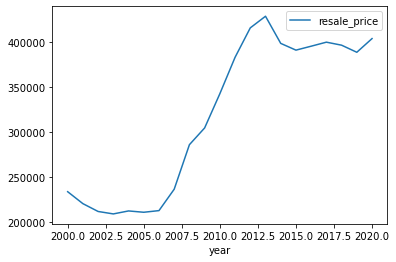

In [ ]:
df_year = train_df.groupby(['year'],as_index=True).mean()[['resale_price']]
df_year.plot(kind='line')

### town colum //check this from last notebook

In [18]:
train_df.town.unique()

array(['pasir ris', 'punggol', 'sengkang', 'clementi', 'bukit batok',
       'jurong west', 'geylang', 'yishun', 'bukit panjang', 'serangoon',
       'jurong east', 'kallang/whampoa', 'hougang', 'woodlands',
       'tampines', 'choa chu kang', 'marine parade', 'toa payoh',
       'queenstown', 'bedok', 'bishan', 'ang mo kio', 'sembawang',
       'bukit merah', 'central area', 'bukit timah'], dtype=object)

In [25]:
test_df.town.unique()

array(['bukit batok', 'tampines', 'jurong east', 'ang mo kio', 'clementi',
       'toa payoh', 'bukit panjang', 'sengkang', 'bishan',
       'choa chu kang', 'jurong west', 'sembawang', 'yishun', 'hougang',
       'bukit merah', 'serangoon', 'kallang/whampoa', 'woodlands',
       'bedok', 'queenstown', 'geylang', 'pasir ris', 'marine parade',
       'punggol', 'central area', 'bukit timah'], dtype=object)

Plot of the locations of hdb's according to town

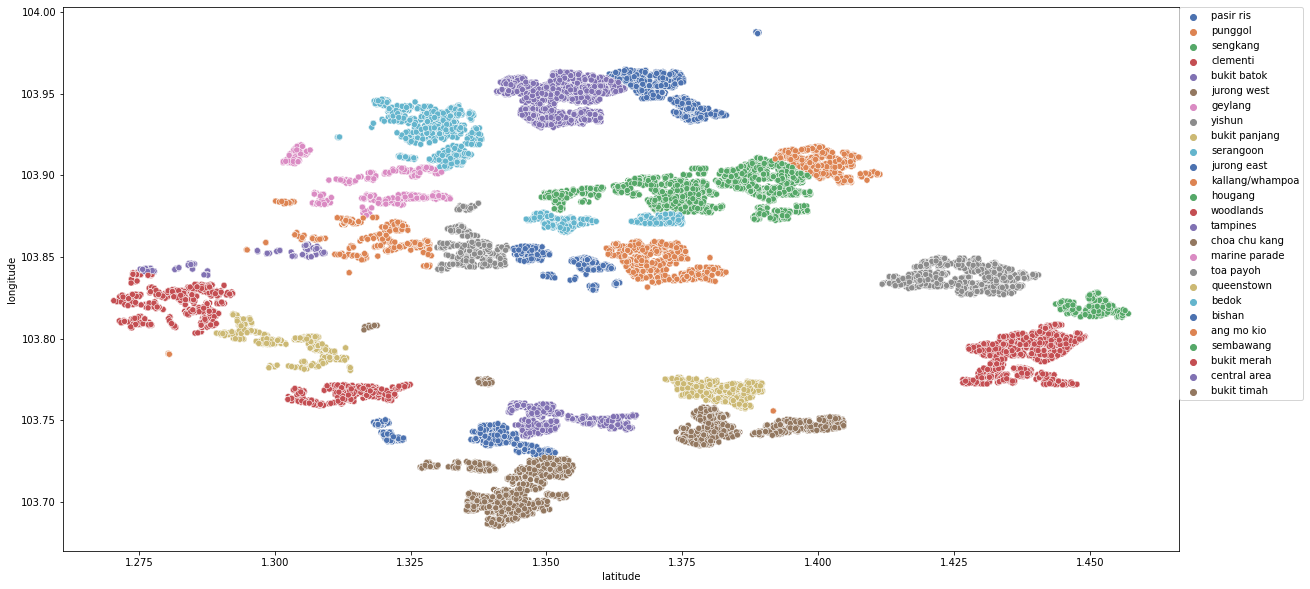

In [53]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=train_df.latitude,y=train_df.longitude,hue=train_df.town,palette="deep")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

### flat_type

In [44]:
train_df['flat_type'].unique()

array(['4 room', '5-room', '5 room', '3 room', '3-room', 'executive',
       '2 room', '4-room', 'multi generation', '2-room', '1-room',
       '1 room'], dtype=object)

In [45]:
train_df["flat_type"].replace({"5 room": "5-room",
                                       "4 room": "4-room",
                                       "3 room": "3-room",
                                       "2 room": "2-room",
                                       "1 room": "1-room"},
                                      inplace=True)
test_df["flat_type"].replace({"5 room": "5-room",
                                       "4 room": "4-room",
                                       "3 room": "3-room",
                                       "2 room": "2-room",
                                       "1 room": "1-room"},
                                      inplace=True)

In [46]:
train_df['flat_type'].unique()

array(['4-room', '5-room', '3-room', 'executive', '2-room',
       'multi generation', '1-room'], dtype=object)

In [47]:
train_df.groupby(['flat_type']).median()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,resale_price
flat_type,,,,,,
1-room,31.0,1975,1.278361,103.819382,0,82170.0
2-room,45.0,1973,1.326222,103.845566,0,171000.0
3-room,67.0,1980,1.345564,103.842529,0,189000.0
4-room,98.0,1992,1.368607,103.838570,0,279000.0
5-room,121.0,1997,1.373261,103.838516,0,360000.0
executive,146.0,1994,1.371992,103.842873,0,441000.0
multi generation,164.0,1987,1.418567,103.840569,0,454500.0


<AxesSubplot:xlabel='flat_type'>

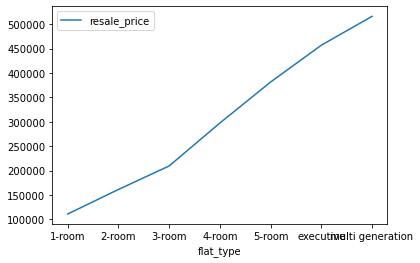

In [ ]:
df_flat_type = train_df.groupby(['flat_type'],as_index=True).mean()[['resale_price']]
df_flat_type.plot(kind='line')

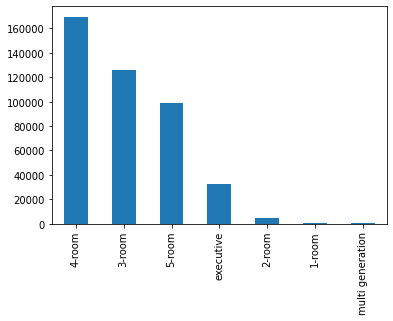

In [48]:
train_df['flat_type'].value_counts().plot(kind='bar')

Plots of the locations of the HDB flats according of Flat type

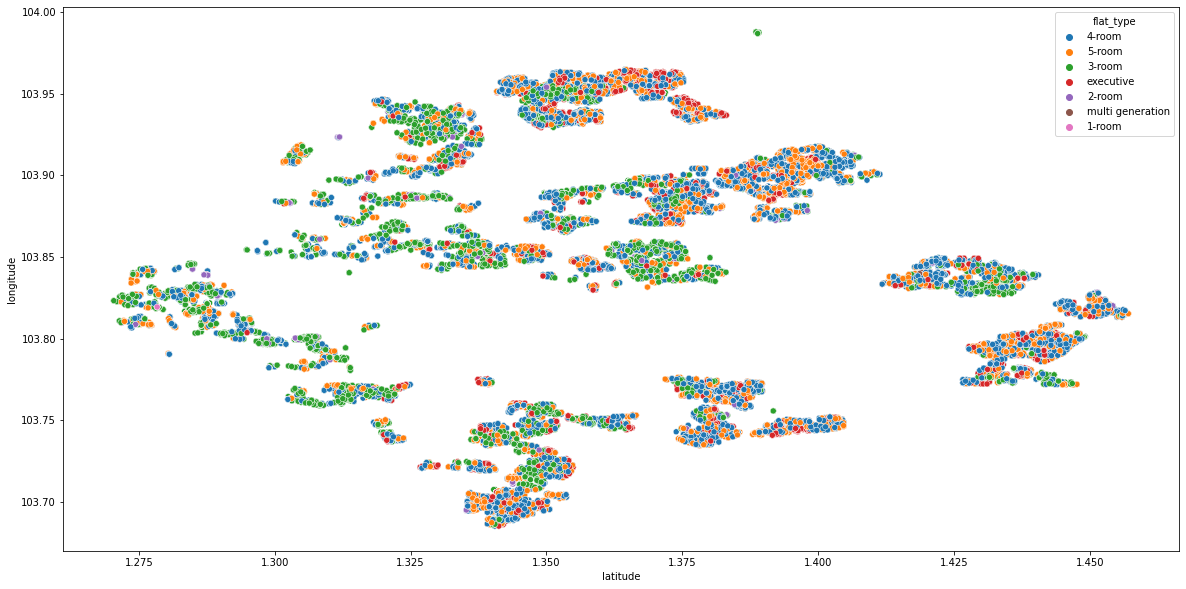

In [54]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=train_df.latitude,y=train_df.longitude,hue=train_df.flat_type)

### block and street_name columns //check this

Removing the duplicate entries arised due to sentence case of the street names. 

Eg - "yishun ring road" and "Yishun Ring Road", both were considered as  different data points earlier but now they are the same entity

In [19]:
pd.set_option('display.max_rows', None)
print(train_df.street_name.value_counts())
print(len(train_df.street_name.value_counts()))

yishun ring road             4392
ang mo kio avenue 10         3547
bedok reservoir road         3433
ang mo kio avenue 3          3066
Yishun Ring Road             2917
hougang avenue 8             2458
Ang Mo Kio Avenue 10         2332
Bedok Reservoir Road         2223
Ang Mo Kio Avenue 3          2089
bedok north street 3         1940
tampines street 21           1882
ang mo kio avenue 4          1848
bedok north road             1770
woodlands ring road          1755
choa chu kang crescent       1660
Hougang Avenue 8             1639
jurong west street 65        1637
marsiling drive              1590
woodlands circle             1584
pasir ris street 71          1578
ang mo kio avenue 5          1568
circuit road                 1533
jurong west street 42        1493
jurong west street 81        1492
jurong east street 21        1448
jelapang road                1430
lorong 1 toa payoh           1428
woodlands drive 14           1375
bukit batok west avenue 6    1370
choa chu kang 

In [21]:
print(train_df.street_name.str.lower().value_counts())
len(train_df.street_name.str.lower().value_counts())

yishun ring road             7309
ang mo kio avenue 10         5879
bedok reservoir road         5656
ang mo kio avenue 3          5155
hougang avenue 8             4097
bedok north street 3         3249
ang mo kio avenue 4          3180
tampines street 21           3090
woodlands ring road          2999
bedok north road             2983
choa chu kang crescent       2852
ang mo kio avenue 5          2707
jurong west street 65        2685
marsiling drive              2682
woodlands circle             2673
pasir ris street 71          2637
circuit road                 2570
jurong west street 81        2521
jurong west street 42        2483
jurong east street 21        2447
jelapang road                2365
lorong 1 toa payoh           2336
woodlands drive 14           2289
choa chu kang avenue 4       2285
simei street 1               2262
bukit batok west avenue 6    2233
rivervale drive              2233
jurong west street 61        2221
woodlands drive 50           2177
punggol field 

553

There are 550 duplicate street names, which is shown by lowering the case of the street names and the unique count of the street name falls from 1103 to 553.

We will have to replace these duplicate street names and we are using the fuzzywuzzy library to do the same.

In [24]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 100):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match

In [26]:
train_street_names_list = train_df["street_name"].str.lower().unique().tolist()
len(train_street_names_list)

553

In [27]:
test_street_names_list = test_df["street_name"].str.lower().unique().tolist()
len(test_street_names_list)

550

In [28]:
train_df["street_name_mod"] = train_df["street_name"].copy()
test_df["street_name_mod"] = test_df["street_name"].copy()

In [29]:
train_df.street_name_mod = train_df.street_name_mod.astype(str)
test_df.street_name_mod = test_df.street_name_mod.astype(str)

In [31]:
for i in train_street_names_list:
  replace_matches_in_column(train_df,column="street_name_mod",string_to_match=i)

In [32]:
for i in test_street_names_list:
  replace_matches_in_column(test_df,column="street_name_mod",string_to_match=i)

In [33]:
len(train_df.street_name_mod.unique())

553

In [34]:
len(test_df.street_name_mod.unique())

550

In [35]:
train_df.drop(columns=["street_name"],inplace=True)

In [36]:
test_df.drop(columns=["street_name"],inplace=True)

### storey_range column

In [ ]:
train_df["storey_range"].unique()

array(['01 to 03', '10 to 12', '07 to 09', '13 to 15', '16 to 18',
       '04 to 06', '22 to 24', '01 to 05', '19 to 21', '11 to 15',
       '06 to 10', '25 to 27', '31 to 33', '28 to 30', '37 to 39',
       '34 to 36', '21 to 25', '16 to 20', '40 to 42', '46 to 48',
       '43 to 45', '26 to 30', '36 to 40', '31 to 35', '49 to 51'],
      dtype=object)

In [ ]:
def get_storey(x):
            low_level = int(x[0:2])
            high_level = int(x[-2:])
            mean_value = (low_level + high_level) * 0.5
            return mean_value
            # print("Changes storey_range 01 to 03 to 2")
train_df['storey'] = train_df['storey_range'].apply(lambda x: get_storey(x))
train_df = train_df.drop('storey_range',1)
test_df['storey'] = test_df['storey_range'].apply(lambda x: get_storey(x))
test_df = test_df.drop('storey_range',1)

In [ ]:
train_df.groupby(['storey']).median()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,resale_price,month_no,year
storey,,,,,,,,
2.0,94.0,1987.0,1.358288,103.839424,0,262800.000,7.0,2008.0
3.0,94.0,1987.5,1.362126,103.838875,0,374400.000,4.0,2012.0
5.0,96.0,1987.0,1.358669,103.840065,0,270000.000,7.0,2008.0
8.0,96.0,1987.0,1.359430,103.840477,0,277200.000,7.0,2008.0
11.0,98.0,1988.0,1.364118,103.839363,0,283500.000,7.0,2008.0
13.0,100.0,1993.0,1.369848,103.837769,0,412200.000,4.0,2012.0
14.0,102.0,1997.0,1.364425,103.849403,0,334800.000,7.0,2009.0
17.0,105.0,1999.0,1.348241,103.845985,0,373500.000,7.0,2010.0
18.0,110.0,2000.0,1.366292,103.840263,0,481500.000,4.0,2012.0


<AxesSubplot:xlabel='storey'>

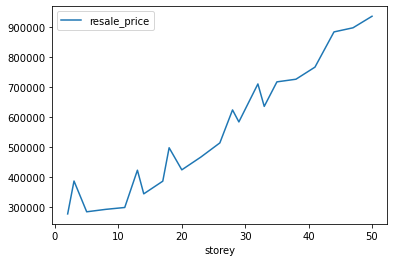

In [ ]:
df_storey = train_df.groupby(['storey'],as_index=True).mean()[['resale_price']]
df_storey.plot(kind='line')

### floor_area_sqm column

In [ ]:
train_df["floor_area_sqm"].unique()

array([118. , 110. , 112. ,  67. ,  73. , 100. ,  60. , 140. , 122. ,
       103. , 106. ,  90. , 133. , 104. ,  47. , 152. ,  65. , 132. ,
        99. ,  84. ,  74. , 115. , 121. , 131. ,  93. , 176. , 164. ,
       107. ,  92. , 105. , 120. , 101. , 123. ,  68. ,  82. ,  81. ,
        79. ,  64. ,  98. ,  91. ,  69. ,  62. ,  85. , 172. , 126. ,
       134. , 102. ,  83. , 129. ,  94. ,  56. ,  88. , 116. ,  45. ,
        38. , 109. ,  59. ,  87. ,  58. , 146. , 145. , 137. ,  96. ,
       108. , 114. ,  86. ,  89. , 163. , 142. ,  66. , 127. , 138. ,
        95. , 192. ,  72. , 156. ,  76. , 148. , 111. ,  46. , 143. ,
       150. , 147. , 125. , 124. , 144. , 149. ,  63. ,  35. , 119. ,
        60.3,  75. , 113. , 130. , 161. ,  97. ,  40. , 117. ,  51. ,
       135. ,  57. ,  70. ,  52. , 139. , 128. ,  54. ,  77. ,  71. ,
        78. , 141. , 155. , 151. , 136. ,  31. ,  63.1, 153. , 173. ,
       154. , 162. ,  44. ,  42. ,  80. , 169. ,  53. ,  48. , 170. ,
       178. , 158. ,

<AxesSubplot:xlabel='floor_area_sqm'>

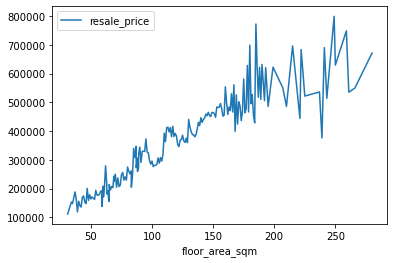

In [ ]:
df_floor_area = train_df.groupby(['floor_area_sqm'],as_index=True).mean()[['resale_price']]
df_floor_area.plot(kind='line')

### flat_model column

In [ ]:
train_df["flat_model"].unique()

array(['model a', 'improved', 'premium apartment', 'new generation',
       'apartment', 'simplified', 'standard', 'adjoined flat',
       'multi generation', 'maisonette', 'model a2', 'model a maisonette',
       'dbss', 'improved maisonette', 'terrace', 'type s1', 'type s2',
       '2 room', 'premium apartment loft', 'premium maisonette'],
      dtype=object)

<AxesSubplot:xlabel='flat_model'>

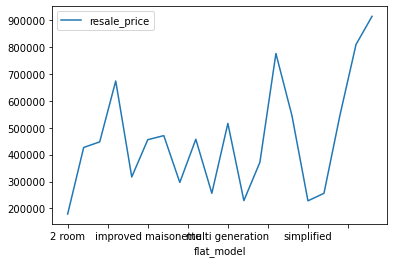

In [ ]:
df_flat_model = train_df.groupby(['flat_model'],as_index=True).mean()[['resale_price']]
df_flat_model.plot(kind='line')

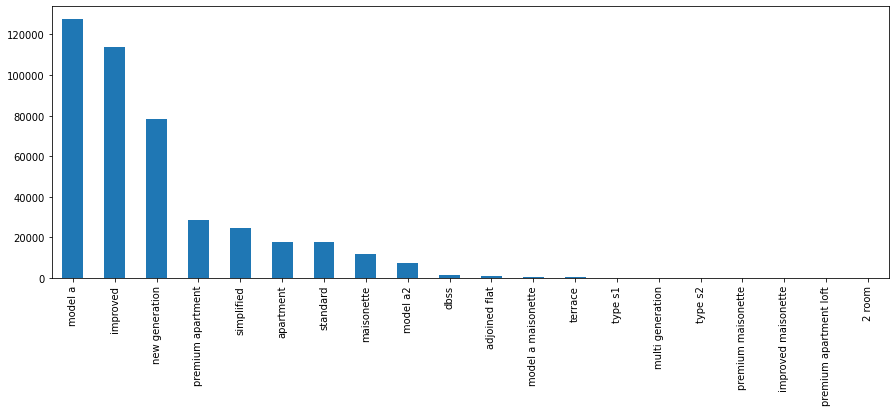

In [42]:
plt.figure(figsize=(15,5))
train_df.flat_model.value_counts().plot(kind='bar')

### eco_category column

In [ ]:
train_df["eco_category"].unique()

array(['uncategorized'], dtype=object)

In [ ]:
train_df = train_df.drop('eco_category',1)
test_df = test_df.drop('eco_category',1)

### lease_commence_date column

In [ ]:
train_df["lease_commence_date"].unique()

array([1989, 2003, 2004, 1980, 1985, 1998, 2000, 1988, 1999, 1992, 1990,
       1993, 1984, 2013, 1975, 1995, 1997, 1994, 1986, 1978, 2005, 1974,
       1983, 1987, 2007, 2001, 1970, 1979, 1996, 1982, 2015, 1969, 2006,
       1981, 2010, 2002, 1968, 2016, 1966, 1991, 1976, 2009, 2012, 1971,
       1967, 1977, 2014, 1972, 1973, 2008, 2011, 2017, 2019, 2018],
      dtype=uint16)

<AxesSubplot:xlabel='lease_commence_date'>

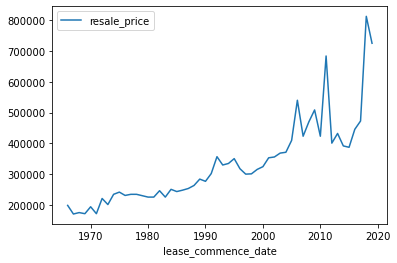

In [ ]:
df_lease_commence_date = train_df.groupby(['lease_commence_date'],as_index=True).median()[['resale_price']]
df_lease_commence_date.plot(kind='line')

<AxesSubplot:xlabel='lease_commence_date'>

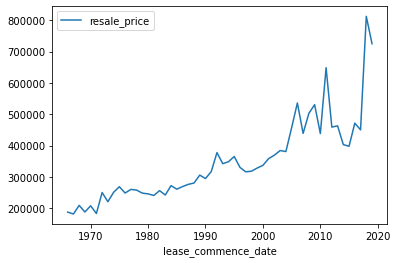

In [ ]:
df_lease_commence_date = train_df.groupby(['lease_commence_date'],as_index=True).mean()[['resale_price']]
df_lease_commence_date.plot(kind='line')

In [ ]:
train_df[['remaining_lease']] = train_df['lease_commence_date'] + 99 - train_df['year']
train_df[['remaining_lease']] = train_df[['remaining_lease']].astype('uint16')

<AxesSubplot:xlabel='remaining_lease'>

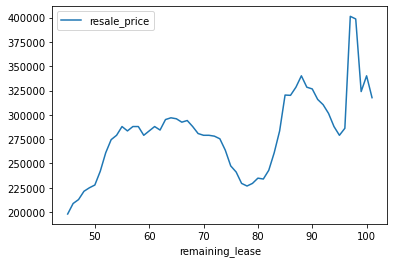

In [ ]:
df_remaining_lease = train_df.groupby(['remaining_lease'],as_index=True).median()[['resale_price']]
df_remaining_lease.plot(kind='line')

In [ ]:
train_df = train_df.drop('remaining_lease',1)

### latitude and logitude column

In [ ]:
train_df["lat_long"] = list(zip(train_df.latitude, train_df.longitude))
print("Clubbed latitude and longitude together (latitude,longitude)")
train_df = train_df.drop('latitude',1)
print("Dropped Column latitude")
train_df = train_df.drop('longitude',1)
print("Dropped Column longitude")

Clubbed latitude and longitude together (latitude,longitude)
Dropped Column latitude
Dropped Column longitude


In [ ]:
test_df["lat_long"] = list(zip(test_df.latitude, test_df.longitude))
print("Clubbed latitude and longitude together (latitude,longitude)")
test_df = test_df.drop('latitude',1)
print("Dropped Column latitude")
test_df = test_df.drop('longitude',1)
print("Dropped Column longitude")

Clubbed latitude and longitude together (latitude,longitude)
Dropped Column latitude
Dropped Column longitude


### elevation column

In [ ]:
train_df["elevation"].unique()

array([0], dtype=uint8)

In [ ]:
train_df = train_df.drop('elevation',1)
test_df = test_df.drop('elevation',1)

### subzone column // check this from previous notebook

In [ ]:
train_df["subzone"].unique()

array(['pasir ris drive', 'punggol field', 'fernvale', 'clementi north',
       'bukit batok west', 'bukit batok east', 'jurong west central',
       'aljunied', 'northland', 'guilin', 'saujana', 'serangoon north',
       'yuhua west', 'lavender', 'hougang east', 'woodlands east',
       'woodgrove', 'tampines west', 'peng siang', 'senja',
       'marine parade', 'toa payoh central', 'tampines east',
       'bukit batok central', 'midview', 'hougang west', 'holland drive',
       'serangoon garden', 'bedok south', 'bishan east', 'potong pasir',
       'yishun west', 'yio chu kang west', 'rivervale', 'balestier',
       'bedok north', 'lorong ah soo', 'yishun south', 'hong kah',
       'woodlands west', 'compassvale', 'khatib', 'sembawang north',
       'yishun east', 'trafalgar', 'woodlands south', 'braddell',
       'chong boon', 'pasir ris west', 'kovan', 'simei',
       'serangoon central', 'geylang east', 'kaki bukit', 'tanglin halt',
       'choa chu kang north', 'crawford', 'faja

<AxesSubplot:xlabel='subzone'>

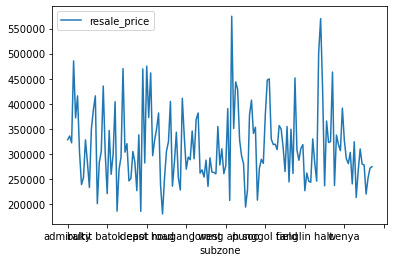

In [ ]:
df_subzone = train_df.groupby(['subzone'],as_index=True).mean()[['resale_price']]
df_subzone.plot(kind='line')

### planning_area column // check this from previous notebook

In [ ]:
train_df["planning_area"].unique()

array(['pasir ris', 'punggol', 'sengkang', 'clementi', 'bukit batok',
       'jurong west', 'geylang', 'yishun', 'bukit panjang', 'serangoon',
       'jurong east', 'kallang', 'hougang', 'woodlands', 'tampines',
       'choa chu kang', 'marine parade', 'toa payoh', 'queenstown',
       'bedok', 'bishan', 'ang mo kio', 'novena', 'sembawang',
       'bukit merah', 'outram', 'sungei kadut', 'bukit timah', 'rochor',
       'changi', 'tanglin', 'downtown core'], dtype=object)

### region column  // check this from previous notebook

In [ ]:
train_df["region"].unique()

array(['east region', 'north-east region', 'west region',
       'central region', 'north region'], dtype=object)

In [ ]:
train_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,resale_price,month_no,year,storey,lat_long
0,pasir ris,4-room,440,pasir ris drive 4,118.0,model a,1989,pasir ris drive,pasir ris,east region,209700.0,8,2001,2.0,"(1.3690080642700195, 103.95869445800781)"
1,punggol,5-room,196B,punggol field,110.0,improved,2003,punggol field,punggol,north-east region,402300.0,10,2014,11.0,"(1.3990070819854736, 103.90699005126953)"
2,sengkang,5-room,404A,fernvale lane,112.0,premium apartment,2004,fernvale,sengkang,north-east region,351000.0,9,2020,2.0,"(1.3883482217788696, 103.87381744384766)"
3,clementi,3-room,375,clementi avenue 4,67.0,new generation,1980,clementi north,clementi,west region,151200.0,10,2000,8.0,"(1.3184930086135864, 103.7667007446289)"
4,bukit batok,3-room,163,bukit batok street 11,73.0,model a,1985,bukit batok west,bukit batok,west region,318600.0,1,2013,8.0,"(1.3481495380401611, 103.74266052246094)"


In [ ]:
test_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,month_no,year,storey,lat_long
0,bukit batok,4-room,186,bukit batok west avenue 6,94.0,new generation,1989,bukit batok west,bukit batok,west region,1,2004,5.0,"(1.3465807437896729, 103.74408721923828)"
1,tampines,5-room,366,tampines street 34,122.0,improved,1997,tampines east,tampines,east region,11,2001,5.0,"(1.3576176166534424, 103.96138000488281)"
2,jurong east,3-room,206,jurong east street 21,67.0,new generation,1982,toh guan,jurong east,west region,7,2002,2.0,"(1.337803840637207, 103.74199676513672)"
3,ang mo kio,3-room,180,Ang Mo Kio Avenue 5,82.0,new generation,1981,yio chu kang east,ang mo kio,north-east region,4,2015,5.0,"(1.380083680152893, 103.84957122802734)"
4,clementi,5-room,356,clementi avenue 2,117.0,standard,1978,clementi north,clementi,west region,4,2004,2.0,"(1.3139597177505493, 103.76982879638672)"


Plot of the locations of the HDB flats according to the resale price range (Higer prices HDB flats are Darker)

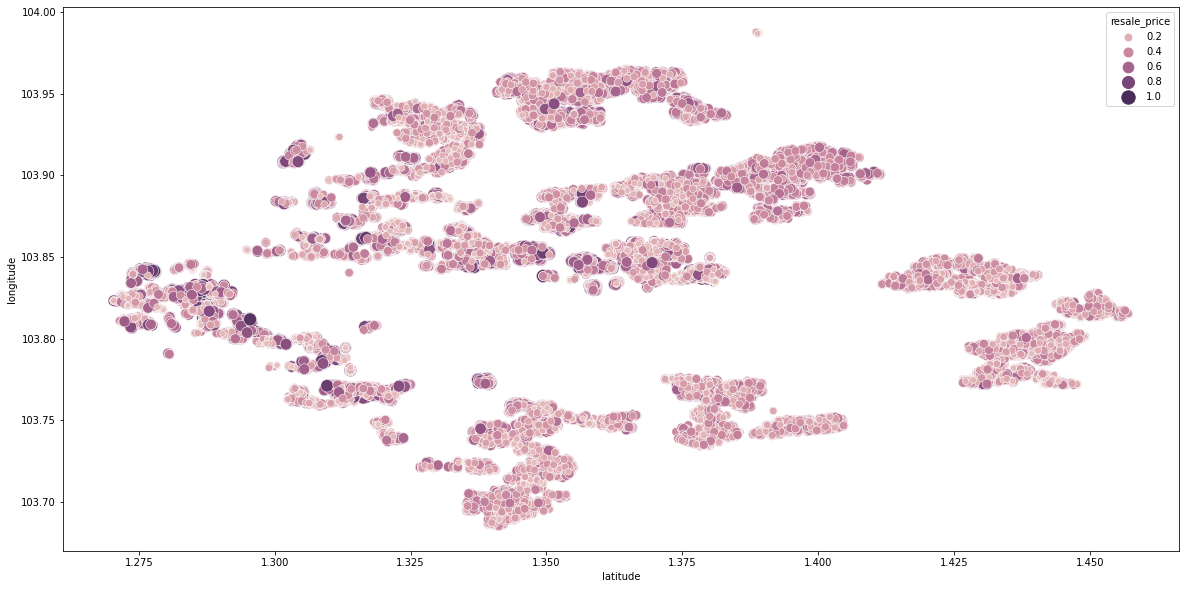

In [55]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=train_df.latitude,y=train_df.longitude,hue=train_df.resale_price,size=train_df.resale_price,sizes=(20, 200))

In [ ]:
train_df.to_csv("./train_1.csv",index=False)
test_df.to_csv("./test_1.csv",index=False)